# SDAE Application: MNIST

In [1]:
# import libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import ExtraTreesClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error,accuracy_score
from tensorflow.keras import regularizers
import math
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import optimizers,initializers,regularizers
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.linear_model import LinearRegression
plt.rcParams["font.family"] = "Times New Roman"


## Load DataSets

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
random.seed(5)

# Ranodom pick 6000 from Training, 4000 from Testing
rows_train_id = random.sample(range(0,X_train.shape[0]), 6000)
X_train = X_train[rows_train_id,:,:]
rows_test_id = random.sample(range(0,X_test.shape[0]), 4000)
X_test = X_test[rows_test_id,:,:]

In [4]:
y_train = y_train[rows_train_id,]
y_test = y_test[rows_test_id,]

In [5]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[1]).astype('float32')/255.0
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[1]).astype('float32')/255.0

In [6]:
X_train.shape

(6000, 784)

In [7]:
X_test.shape

(4000, 784)

## SDAE functions

In [8]:
# Weighted layer defintion with zero-to-one clipping constraint and 1s initialzation with Lasso regularization
class SelectiveLayer(keras.layers.Layer):
    def __init__(self, lasso_rate=0.001,convergence_rate=0.001,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lasso_rate = lasso_rate
        #self.convergence_rate = convergence_rate
    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=(int(input_shape[-1]),), 
                                      initializer = initializers.RandomUniform(minval=0.999999, maxval=0.9999999),
                                      regularizer=regularizers.l1(self.lasso_rate),
                                      constraint = ZeroToOneClip()
                                     )
    def call(self, inputs):
        return tf.multiply(inputs, self.kernel)
    def get_config(self):
        config = super().get_config().copy()
        return config


class ZeroToOneClip(tf.keras.constraints.Constraint):
    def __call__(self, w):
        w_new = tf.clip_by_value(w, 0, 1)
        return w_new



def SelectDAE(input_shape,
                  nbr_hidden_layers =1,
                  hidden_layer_shape=13,
                  encodings_nbr = 6,
                  activation="linear",
                  lasso_rate=0.001,
                  sl_lasso_rate=0.1):
    #Encoder 1:Input
    feature_inputs = Input(shape=[input_shape],name='input')
    #Encoder 2: Input
    selective_layer = SelectiveLayer(lasso_rate=sl_lasso_rate)
    feature_selection_choose = selective_layer(feature_inputs)
    
    for i in range(nbr_hidden_layers):
        #Encoder 1: hidden layers
        encoder_layer_full = Dense(hidden_layer_shape, activation=activation,
                            name='encoder_hidden_layer_full_'+str(i))
        #Encoder 2: hidden layers
        encoder_layer_select = Dense(hidden_layer_shape, activation=activation,
                            kernel_regularizer=regularizers.l1(lasso_rate),
                            bias_regularizer=regularizers.l1(lasso_rate),
                            name='encoder_hidden_layer_select_'+str(i))
        if i==0:
            encoder_layer_full_output = encoder_layer_full(feature_inputs)
            encoder_layer_select_output = encoder_layer_select(feature_selection_choose)
        else:
            encoder_layer_full_output = encoder_layer_full(encoder_layer_full_output)
            encoder_layer_select_output = encoder_layer_select(encoder_layer_select_output)
    
    #Encoder 1: Encodings
    encoding_layer_full = Dense(encodings_nbr, activation=activation,
                           name='encoding_layer_full')
    encoding_layer_full_output = encoding_layer_full(encoder_layer_full_output)
    
    #Encoder 2: Encodings
    encoding_layer_select = Dense(encodings_nbr, activation=activation,
                           kernel_regularizer=regularizers.l1(lasso_rate),
                           bias_regularizer=regularizers.l1(lasso_rate),
                           name='encoding_layer_select')
    encoding_layer_select_output = encoding_layer_select(encoder_layer_select_output)
    
    #Decoder Layers
    for i in range(nbr_hidden_layers):
        decoder_layer = Dense(hidden_layer_shape, activation=activation,
                            name='decoder_hidden_layer_'+str(i))
        if i==0:
            decoder_layer_full_output = decoder_layer(encoding_layer_full_output)
            decoder_layer_select_output = decoder_layer(encoding_layer_select_output)
        else:
            decoder_layer_full_output = decoder_layer(decoder_layer_full_output)
            decoder_layer_select_output = decoder_layer(decoder_layer_select_output)
    
    #Reconstruction Layer
    reconstruction_layer = Dense(input_shape, activation='linear',
                                 name='reconstruction_layer')
    recons_layer_full_output = reconstruction_layer(decoder_layer_full_output)
    recons_layer_select_output = reconstruction_layer(decoder_layer_select_output)

    latent_encoder_full = Model(feature_inputs, encoding_layer_full_output,name='fullFeats_Encoder')
    latent_encoder_select = Model(feature_inputs, encoding_layer_select_output,name='SelectFeats_Encoder')
    feature_selection_output=Model(feature_inputs,feature_selection_choose,name='SelectFeats_Layer')
    autoencoder = Model(feature_inputs, recons_layer_full_output,name='DAE')
    autoencoder_select = Model(feature_inputs, recons_layer_select_output,name='SelectDAE')   
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    
    print('SelectEncoder Structure-------------------------------------')
    latent_encoder_select.summary()
    
    return autoencoder,autoencoder_select,feature_selection_output, latent_encoder_full,latent_encoder_select



def top_k_keep(p_arr_,p_top_k_):
    top_k_idx=p_arr_.argsort()[::-1][0:p_top_k_]
    top_k_value=p_arr_[top_k_idx]
    #print(str(top_k_value))
    return np.where(p_arr_<top_k_value[-1],0,p_arr_)

def show_feature_selection(autoencoder,p_key_number=36):
    data = autoencoder.layers[1].get_weights()[0]
    weight_top_k=top_k_keep(np.array(data),p_key_number)
    eliminated_feats = np.where(weight_top_k==0)[0]
    survived_feats = np.where(weight_top_k!=0)[0]
    return weight_top_k,eliminated_feats,survived_feats

## Build Model

In [9]:
#For Repeatability: select a run from 0->4
run = 4 #0,1,2,3,4
seed_list = [0,10,100,1000,10000]
lasso_rate_SL_list = [5.26e-1,5.1e-1,6.6e-1,5.1e-1,5.8e-1]

#parameters
seed = seed_list[run]
lasso_rate = 1e-6
hidden_layer_shape = 100
nbr_hidden_layers =3
encodings_nbr = 100
lasso_rate_SL = lasso_rate_SL_list[run]
activation = 'selu'
learning_rate = 1e-3
nbr_batches = 20
batch_size = int(np.floor(X_train.shape[0]/nbr_batches))

#Set seed
random.seed(seed)
rndm_seed = random.randint(1,10000)
tf.random.set_seed(rndm_seed)

DAE,\
Select_DAE,\
SelectLayer_output,\
FullFeats_Encoder,\
SelectFeats_Encoder=SelectDAE(input_shape=X_train.shape[1],
                              nbr_hidden_layers = nbr_hidden_layers,
                              hidden_layer_shape=hidden_layer_shape,
                              encodings_nbr =encodings_nbr,
                              activation=activation,
                              lasso_rate=lasso_rate,
                              sl_lasso_rate=lasso_rate_SL)

Autoencoder Structure-------------------------------------
Model: "DAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_hidden_layer_full_0  (None, 100)              78500     
  (Dense)                                                        
                                                                 
 encoder_hidden_layer_full_1  (None, 100)              10100     
  (Dense)                                                        
                                                                 
 encoder_hidden_layer_full_2  (None, 100)              10100     
  (Dense)                                                        
                                                                 
 encoding_layer_full (Dense)  (None, 100)              10100     
    

                                                                 
 selective_layer (SelectiveL  (None, 784)              784       
 ayer)                                                           
                                                                 
 encoder_hidden_layer_select  (None, 100)              78500     
 _0 (Dense)                                                      
                                                                 
 encoder_hidden_layer_select  (None, 100)              10100     
 _1 (Dense)                                                      
                                                                 
 encoder_hidden_layer_select  (None, 100)              10100     
 _2 (Dense)                                                      
                                                                 
 encoding_layer_select (Dens  (None, 100)              10100     
 e)                                                              
          

In [10]:
#Pre-training
DAE.compile(loss='mean_squared_error',optimizer=optimizers.Adam())
DAE.fit(X_train,X_train,epochs=400,batch_size=batch_size,\
                        shuffle=True
                       )

Epoch 1/400
20/20 [==============================] - 1s 20ms/step - loss: 0.1205
Epoch 2/400
20/20 [==============================] - 0s 20ms/step - loss: 0.0652
Epoch 3/400
20/20 [==============================] - 0s 20ms/step - loss: 0.0568
Epoch 4/400
20/20 [==============================] - 0s 20ms/step - loss: 0.0491
Epoch 5/400
20/20 [==============================] - 0s 20ms/step - loss: 0.0427
Epoch 6/400
20/20 [==============================] - 0s 20ms/step - loss: 0.0387
Epoch 7/400
20/20 [==============================] - 0s 20ms/step - loss: 0.0360
Epoch 8/400
20/20 [==============================] - 0s 20ms/step - loss: 0.0338
Epoch 9/400
20/20 [==============================] - 0s 20ms/step - loss: 0.0319
Epoch 10/400
20/20 [==============================] - 0s 20ms/step - loss: 0.0303
Epoch 11/400
20/20 [==============================] - 0s 20ms/step - loss: 0.0288
Epoch 12/400
20/20 [==============================] - 0s 20ms/step - loss: 0.0275
Epoch 13/400
20/20 [=====

In [11]:
train_prediction_all_feats = DAE.predict(X_train)
print('Training:')
print('MSE Full Feats: '+str(mean_squared_error(X_train,train_prediction_all_feats)))

188/188 [==============================] - 1s 3ms/step
Training:
MSE Full Feats: 0.008017326


In [12]:
test_prediction_all_feats = DAE.predict(X_test)
print("Testing:")
print('MSE Full Feats: '+str(mean_squared_error(X_test,test_prediction_all_feats)))

125/125 [==============================] - 1s 5ms/step
Testing:
MSE Full Feats: 0.008354978


In [13]:
#Transfer Learning
for lay in range(nbr_hidden_layers+1):
    SelectFeats_Encoder.layers[-(1+lay)].set_weights(FullFeats_Encoder.layers[-(1+lay)].get_weights())


In [14]:
# Feature Selection Training
SelectFeats_Encoder.compile(loss='mean_squared_error',optimizer=optimizers.Adam(),metrics='mse')
DAE_encodings_train_scal = FullFeats_Encoder.predict(X_train)
SelectFeats_Encoder.fit(X_train,DAE_encodings_train_scal,epochs=600,batch_size=batch_size,\
                        shuffle=True)

188/188 [==============================] - 1s 3ms/step
Epoch 1/600
20/20 [==============================] - 1s 12ms/step - loss: 450.4372 - mse: 0.0310
Epoch 2/600
20/20 [==============================] - 0s 12ms/step - loss: 441.3168 - mse: 0.0050
Epoch 3/600
20/20 [==============================] - 0s 12ms/step - loss: 432.2192 - mse: 0.0016
Epoch 4/600
20/20 [==============================] - 0s 12ms/step - loss: 423.1243 - mse: 8.4783e-04
Epoch 5/600
20/20 [==============================] - 0s 12ms/step - loss: 414.0299 - mse: 6.4527e-04
Epoch 6/600
20/20 [==============================] - 0s 12ms/step - loss: 404.9356 - mse: 5.6948e-04
Epoch 7/600
20/20 [==============================] - 0s 12ms/step - loss: 395.8413 - mse: 5.3787e-04
Epoch 8/600
20/20 [==============================] - 0s 12ms/step - loss: 386.7471 - mse: 5.2639e-04
Epoch 9/600
20/20 [==============================] - 0s 11ms/step - loss: 377.6527 - mse: 5.2623e-04
Epoch 10/600
20/20 [============================

In [15]:
train_prediction_select_feats = Select_DAE.predict(X_train)
print('Training:')
print('MSE Select Feats: '+str(mean_squared_error(X_train,train_prediction_select_feats)))

188/188 [==============================] - 1s 3ms/step
Training:
MSE Select Feats: 0.026829459


In [16]:
survived_feats = len(np.where(SelectLayer_output.layers[1].get_weights()[0]>=1e-6)[0])
print('Number of Important Features = '+str(survived_feats))

Number of Important Features = 46


In [17]:
wghts_final = SelectLayer_output.layers[1].get_weights()[0]
print(wghts_final)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.000

In [18]:
test_prediction_select_feats = Select_DAE.predict(X_test)
print('Testing:')
print('MSE Select Feats: '+str(mean_squared_error(X_test,test_prediction_select_feats)))

125/125 [==============================] - 1s 4ms/step
Testing:
MSE Select Feats: 0.026476845


In [19]:
_,_,top_k_feats = show_feature_selection(SelectLayer_output,p_key_number=survived_feats)
print(top_k_feats)

[154 157 179 184 213 236 239 244 260 264 268 291 322 323 325 345 348 371
 378 400 406 409 411 413 430 458 461 465 466 469 492 496 518 521 523 543
 567 568 571 574 606 625 631 654 657 660]


In [20]:
X_train_mask = X_train[:,top_k_feats]
X_test_mask = X_test[:,top_k_feats]
LR = LinearRegression(n_jobs = -1)
LR.fit(X_train_mask,X_train)
MSELR = mean_squared_error(X_test,LR.predict(X_test_mask))

In [21]:
print('Linear Reconstruction Error = '+str(MSELR))

Linear Reconstruction Error = 0.021785604


In [22]:
X_train_mask = X_train[:,top_k_feats]
X_test_mask = X_test[:,top_k_feats]


In [23]:
clf = ExtraTreesClassifier(n_estimators=50, random_state=0)
clf.fit(X_train_mask,y_train)
y_pred = clf.predict(X_test_mask)

In [24]:
print('Accuracy Score = '+str(accuracy_score(y_test,y_pred)*100))

Accuracy Score = 90.275


## Extra Visualizations

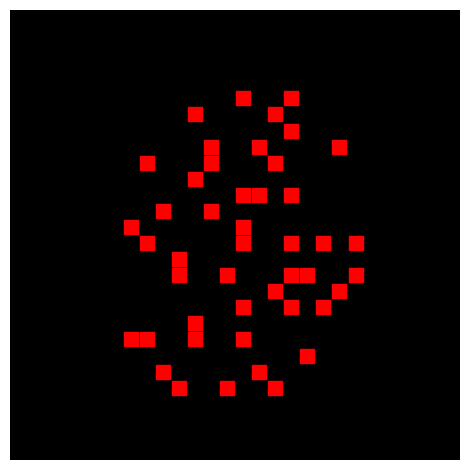

46


In [25]:
plt.axis('off')
canvas=np.zeros((28,28))
plt.imshow(canvas,plt.cm.gray)

wghts_final_copy = wghts_final.reshape((28,28))

for index_i in np.arange(wghts_final_copy.shape[0]):
    for index_j in np.arange(wghts_final_copy.shape[1]): 
        if wghts_final_copy[index_i,index_j]>0.00001:
            plt.scatter(index_j,index_i,s=100,color='r',marker="s")
plt.tight_layout()
plt.show()
print(np.sum(wghts_final_copy.flatten()>1e-6))

In [26]:
def show_data_figures(p_data,w=28,h=28,columns = 4):
    rows = math.ceil(len(p_data)/columns)
    fig_show_w=columns
    fig_show_h=rows
    fig=plt.figure(figsize=(fig_show_w, fig_show_h))
    for i in range(0, len(p_data)):
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.imshow(p_data[i,:].reshape((w, h)),plt.cm.gray)#
    plt.show()
    
def show_image_feature_selection(wghts,p_test_data,p_sample_number=20):
    show_data_figures(np.dot(p_test_data[0:p_sample_number],np.diag(wghts.flatten())))

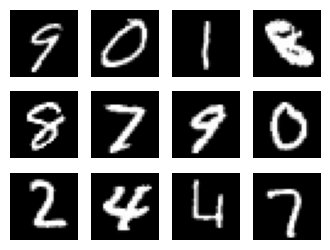

In [27]:
show_data_figures(X_test[0:12],28,28,4)

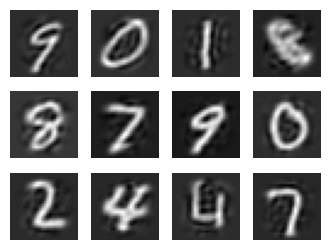

In [28]:
show_data_figures(test_prediction_all_feats[0:12],28,28,4)

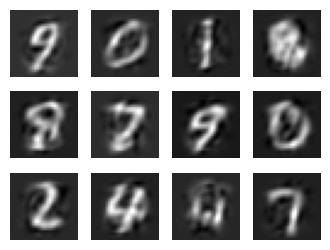

In [29]:
show_data_figures(test_prediction_select_feats[0:12],28,28,4)

In [30]:
y_pred[0:12]

array([9, 0, 1, 9, 8, 7, 9, 0, 2, 4, 6, 7], dtype=uint8)

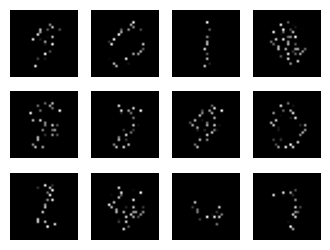

In [31]:
show_image_feature_selection(wghts_final,X_test[:12],p_sample_number=16)